# import essential librarys and Set up GPU

In [1]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
import glob
from pathlib import Path
from collections import namedtuple
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
%matplotlib inline
pd.set_option('display.max_colwidth', 1000)

#set up GPU (optional)
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"
from tensorflow.python.client import device_lib
print( device_lib.list_local_devices())
import sys
sys.path.append('/extra/pjsadows0/libs/shared/gpu_lock/')


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 830107783414004098
xla_global_id: -1
]


# Read raw PQDs signal voltage

In [2]:
path = os.getcwd()
## 16Khz data
path+="\\code\\16Khz samples.mat"

##8Khz data
# path+="\\code\\8Khz samples.mat")

data_set = loadmat(path)
df=pd.DataFrame(data_set['table'])
df.rename(columns={0: 'Class_number'},inplace=True)
df.tail()

,Class_number,1,2,3,4,5,6,7,8,9,...,3191,3192,3193,3194,3195,3196,3197,3198,3199,3200
8695,29.0,-0.365714,-0.383917,-0.401972,-0.419872,-0.437611,-0.455180,-0.472574,-0.489786,-0.506809,...,-0.177111,-0.196400,-0.215614,-0.234744,-0.253784,-0.272726,-0.291563,-0.310287,-0.328892,-0.347370
8696,29.0,0.704333,0.718135,0.731659,0.744902,0.757858,0.770521,0.782887,0.794952,0.806710,...,0.552311,0.568572,0.584614,0.600430,0.616015,0.631362,0.646466,0.661321,0.675921,0.690260
8697,29.0,-0.645396,-0.630275,-0.614910,-0.599309,-0.583476,-0.567418,-0.551142,-0.534653,-0.517958,...,-0.782015,-0.769627,-0.756943,-0.743966,-0.730703,-0.717159,-0.703338,-0.689245,-0.674887,-0.660269
8698,29.0,0.965125,0.970079,0.974658,0.978863,0.982689,0.986137,0.989205,0.991891,0.994195,...,0.895507,0.904073,0.912289,0.920154,0.927665,0.934817,0.941610,0.948039,0.954103,0.959799
8699,29.0,-0.244130,-0.263122,-0.282014,-0.300796,-0.319462,-0.338006,-0.356419,-0.374694,-0.392825,...,-0.050252,-0.069851,-0.089423,-0.108961,-0.128457,-0.147903,-0.167292,-0.186617,-0.205870,-0.225043


# Add PQDs name to dataframe

In [25]:
PQD={
1 : "Pure sinusoidal",
2 : "Sag",
3 : "Swell",
4 : "Interruption",
5 : "Transient/Impulse/Spike",
6 : "Oscillatory transient",
7 : "Harmonics",
8  : "Harmonics with Sag",
9  : "Harmonics with Swell",
10 : "Flicker",
11 : "Flicker with Sag",
12 : "Flicker with Swell",
13 : "Sag with Oscillatory transient",
14 : "Swell with Oscillatory transient",
15 : "Sag with Harmonics",
16 : "Swell with Harmonics",
17 : "Notch",
18 : "Harmonics with Sag with Flicker",
19 : "Harmonics with Swell with Flicker",
20 : "Sag with Harmonics with Flicker",
21 : "Swell with Harmonics with Flicker",
22 : "Sag with Harmonics with Oscillatory transient",
23 : "Swell with Harmonics with Oscillatory transient",
24 : "Harmonics with Sag with Oscillatory transient",
25 : "Harmonics with Swell with Oscillatory transient",
26 : "Harmonics with Sag with Flicker with Oscillatory transient",
27 : "Harmonics with Swell with Flicker with Oscillatory transient",
28 : "Sag with Harmonics with Flicker with Oscillatory transient",
29 : "Swell with Harmonics with Flicker with Oscillatory transient"
}

df.insert(1, 'PQD_name', df["Class_number"].map(PQD))
# df.insert(2, 'PQD Group', df["Class_number"].map(PQD))

df.head()


,Class_number,PQD_name,1,2,3,4,5,6,7,8,...,3191,3192,3193,3194,3195,3196,3197,3198,3199,3200
0,1.0,Pure sinusoidal,-0.918443,-0.926032,-0.933264,-0.940136,-0.946646,-0.952791,-0.958569,-0.963977,...,-0.823626,-0.834603,-0.845257,-0.855585,-0.865584,-0.875249,-0.884577,-0.893563,-0.902205,-0.910500
1,1.0,Pure sinusoidal,-0.557961,-0.574147,-0.590111,-0.605848,-0.621352,-0.636615,-0.651634,-0.666401,...,-0.385341,-0.403384,-0.421272,-0.438997,-0.456553,-0.473933,-0.491130,-0.508138,-0.524950,-0.541560
2,1.0,Pure sinusoidal,0.715879,0.702032,0.687915,0.673532,0.658890,0.643994,0.628849,0.613462,...,0.838340,0.827475,0.816291,0.804793,0.792984,0.780869,0.768454,0.755742,0.742739,0.729449
3,1.0,Pure sinusoidal,-0.517798,-0.534495,-0.550986,-0.567265,-0.583324,-0.599159,-0.614763,-0.630130,...,-0.340949,-0.359340,-0.377593,-0.395701,-0.413656,-0.431451,-0.449080,-0.466536,-0.483812,-0.500902
4,1.0,Pure sinusoidal,-0.739036,-0.725667,-0.712018,-0.698095,-0.683902,-0.669446,-0.654732,-0.639765,...,-0.856261,-0.845954,-0.835321,-0.824367,-0.813094,-0.801508,-0.789613,-0.777413,-0.764914,-0.752120


# Prepare 1D-signal for machine learning algorithms

In [26]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

X = df.iloc[:,2:].astype(float)
Y = df.loc[:,"Class_number"]

scaler = StandardScaler()
X = scaler.fit_transform(X)

## encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
## convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

# Classifing PQD using DescisionTreeClassifier

Accuracy: 0.07126436781609195


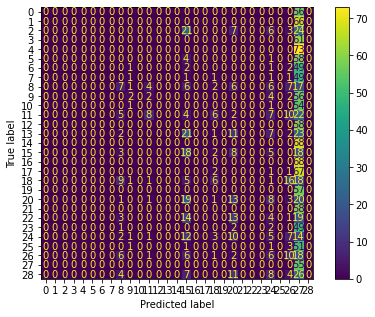

In [30]:
from sklearn.tree import DecisionTreeClassifier
  
# dividing X, y into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size=0.2)
# X_train, X_test, y_train, y_test = train_test_split(X, dummy_y,test_size=0.15)  
dtree_model = DecisionTreeClassifier(max_depth =4).fit(X_train, y_train)
y_pred = dtree_model.predict(X_test)
accuracy = dtree_model.score(X_test, y_test)  
cm = confusion_matrix(y_test, y_pred)
print("Accuracy:",accuracy)
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
cmp.plot(ax=ax)
plt.show();

# Classifing PQD using SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
svm_model_linear = SVC(kernel = 'rbf', C = 1).fit(X_train, y_train)
y_pred = svm_model_linear.predict(X_test)

# model accuracy for X_test
accuracy = svm_model_linear.score(X_test, y_test)
print("Accuracy:",accuracy)
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred),)
cmp.plot(ax=ax)
plt.show();

# Classifing PQD using Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

Random_forest = RandomForestClassifier().fit(X_train,y_train)
y_pred = Random_forest.predict(X_test)

# model accuracy for X_test
accuracy = Random_forest.score(X_test, y_test)

# creating a confusion matrix
print("Accuracy:",accuracy)
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
cmp.plot(ax=ax)
plt.show();

# Classifing PQD using AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

model= AdaBoostClassifier().fit(X_train,y_train)
y_pred = model.predict(X_test)

# model accuracy for X_test
accuracy = model.score(X_test, y_test)

# creating a confusion matrix
print("Accuracy:",accuracy)
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
cmp.plot(ax=ax)
plt.show();

#  Classifing PQD using DNN Model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from numpy import array
from numpy.random import uniform
from numpy import hstack
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing,metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def DNNModel(X,Y):
    xtrain, xtest, ytrain, ytest=train_test_split(X, Y, test_size=0.2)

    in_dim = X.shape[1]
    out_dim = Y.shape[1]
    model = Sequential()
    model.add(Dense(3200, input_dim=in_dim, activation="relu"))
    model.add(Dense(1600, activation="relu"))
    model.add(Dense(800, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(29, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    history=model.fit(xtrain,ytrain, epochs=50, batch_size=32,verbose=1,validation_data=(xtest, ytest))
    test_loss=history.history['val_loss']
    plt.figure(1)
    plt.plot(history.history['loss'])

    plt.figure(2)
    plt.plot(sorted(test_loss,reverse=True),c='g')
    print(model.summary())
    return model,xtest,ytest

DNNmodel1,xtest1,ytest1=DNNModel(X,dummy_y)

_, accuracy = DNNmodel1.evaluate(xtest1,ytest1, batch_size=32, verbose=0)
score = accuracy * 100.0
print(score)

#  Classifing PQD using 1D CNN 

In [42]:
from keras.models import Sequential
from keras.layers import Dense,Reshape, UpSampling1D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D, AveragePooling1D
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

def create_model(input_shape,out_shape):
    convnet = Sequential()

    # WDCNN
    convnet.add(Conv1D(filters=32, kernel_size=32, strides=16, activation='relu', padding='same',input_shape=input_shape))
    convnet.add(MaxPooling1D(strides=2))
    convnet.add(Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding='same'))
    convnet.add(MaxPooling1D(strides=2))
    convnet.add(Dropout(0.4))
    convnet.add(Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding='same'))
    convnet.add(MaxPooling1D(strides=2))
    convnet.add(Dropout(0.4))
    convnet.add(Conv1D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'))
    convnet.add(MaxPooling1D(strides=2))
    convnet.add(Dropout(0.4))
    convnet.add(Conv1D(filters=64, kernel_size=3, strides=1, activation='relu'))
    convnet.add(MaxPooling1D(strides=1))
    convnet.add(Flatten())
    convnet.add(Dense(32, activation='relu'))
    convnet.add(Dense(out_shape, activation='softmax'))
    convnet.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    convnet.summary()
    return convnet

In [ ]:
trainX, testX,trainy,testy = train_test_split(X, dummy_y,test_size=0.2)
params=[trainX, testX,trainy,testy]
model = create_model((trainX.shape[1],1),trainy.shape[1])
model.fit(params[0], params[2], epochs=1, batch_size=32, verbose=1)
_, accuracy = model.evaluate(params[1], params[3], batch_size=32, verbose=1)
score = accuracy * 100.0
print(score)

# Using CWT & Transfer earning

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from sklearn.preprocessing import MinMaxScaler,StandardScaler

##Read and prepare Data 
path = os.getcwd()
## 8Khz data
path+="\\code\\8Khz samples.mat"
data_set = loadmat(path)
df=pd.DataFrame(data_set['table'])
df.rename(columns={0: 'Class_number'},inplace=True)
df.head()
PQD={
1 : "Pure sinusoidal",
2 : "Sag",
3 : "Swell",
4 : "Interruption",
5 : "Transient/Impulse/Spike",
6 : "Oscillatory transient",
7 : "Harmonics",
8  : "Harmonics with Sag",
9  : "Harmonics with Swell",
10 : "Flicker",
11 : "Flicker with Sag",
12 : "Flicker with Swell",
13 : "Sag with Oscillatory transient",
14 : "Swell with Oscillatory transient",
15 : "Sag with Harmonics",
16 : "Swell with Harmonics",
17 : "Notch",
18 : "Harmonics with Sag with Flicker",
19 : "Harmonics with Swell with Flicker",
20 : "Sag with Harmonics with Flicker",
21 : "Swell with Harmonics with Flicker",
22 : "Sag with Harmonics with Oscillatory transient",
23 : "Swell with Harmonics with Oscillatory transient",
24 : "Harmonics with Sag with Oscillatory transient",
25 : "Harmonics with Swell with Oscillatory transient",
26 : "Harmonics with Sag with Flicker with Oscillatory transient",
27 : "Harmonics with Swell with Flicker with Oscillatory transient",
28 : "Sag with Harmonics with Flicker with Oscillatory transient",
29 : "Swell with Harmonics with Flicker with Oscillatory transient"
}

df.insert(1, 'PQD_name', df["Class_number"].map(PQD))
df.head()

X = df.iloc[:,2:].astype(float)
Y = df.loc[:,"Class_number"]

scaler = StandardScaler()
X = scaler.fit_transform(X)

## encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

## convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)
X_train, X_test, y_train, y_test = train_test_split(X, dummy_y,test_size=0.2)

X_train.shape,y_train.shape

((6960, 800), (6960, 29))

# Addining Noise to the Data

In [ ]:
def noise_rw(x,snr,isplot = False):
    snr1 = 10 ** (snr / 10.0)
    xpower = np.sum(x ** 2,axis=1) / x.shape[1]
    npower = np.resize(xpower / snr1,x.shape)
    noise = np.random.normal(0, np.sqrt(npower), x.shape)
    noise_data=x+noise
    if(isplot):
        print(snr,snr1,npower)
        print(np.sum(noise ** 2)/len(x))
        fig, axs = plt.subplots(nrows=3,ncols=x.shape[1], figsize=(8*x.shape[1], 6))
        for i in range(x.shape[1]):
            axs[0][i].plot(x[:,i])
            axs[0][i].set_title(signal_labels[i] + ' signal')
            axs[0][i].get_xaxis().set_visible(False)
            axs[1][i].plot(noise[:,i])
            axs[1][i].set_title(signal_labels[i] +' noise')
            axs[1][i].get_xaxis().set_visible(False)
            axs[2][i].plot(noise_data[:,i])
            axs[2][i].set_title(signal_labels[i] +' noise signal')
        plt.show()
    return noise_data,noise

X_clean = df.iloc[:,2:].astype(float)
X_noise_20dB,noise_20dB=noise_rw(X_clean,20)
X_noise_30dB,noise_30dB=noise_rw(X_clean,30)

X_train_noisy, X_test_noisy, y_train_noisy, y_test_noisy = train_test_split(X_noise_20dB, dummy_y,test_size=0.2)

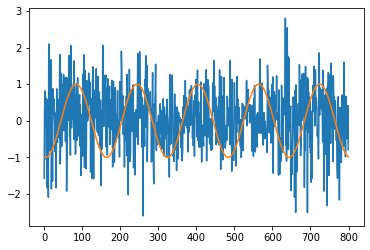

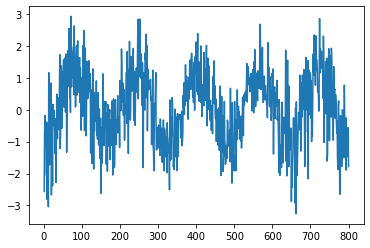

In [21]:
sample=0
plt.plot(noise_20dB[sample][:5000])
plt.plot(X_clean.iloc[sample,:5000])
plt.figure()
plt.plot(X_noise_20dB.iloc[sample,:5000])

# Converting 1-D Signal voltage to 2-D gray image using CWT

0
shapes (n_samples, x_img, y_img, z_img) of X_cwt: (2, 224, 224)


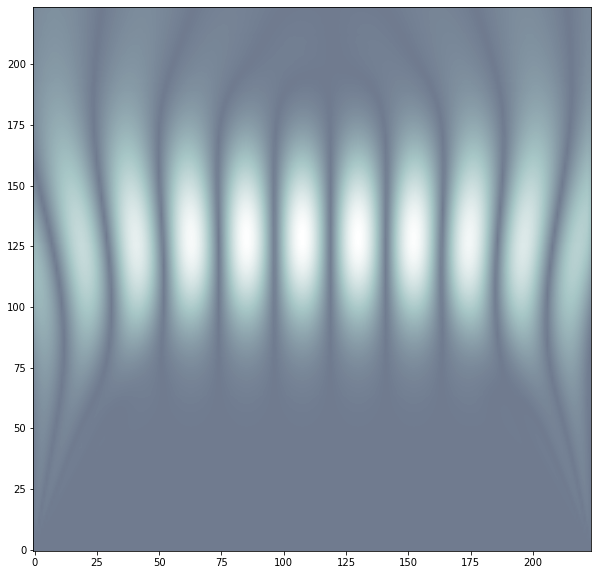

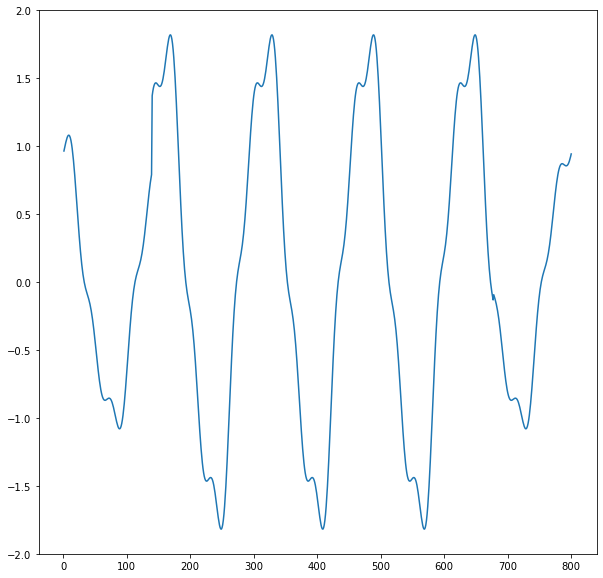

In [53]:
from skimage.transform import resize
import pywt

def create_cwt_images(X, n_scales, rescale_size, wavelet_name = "morl"):
    n_samples = X.shape[0] 
    n_signals = X.shape[1] 
    
    # range of scales from 1 to n_scales
    scales = np.arange(1, n_scales + 1) 
    
    # pre allocate array
    X_cwt = np.ndarray(shape=(n_samples, rescale_size, rescale_size), dtype = 'float32')
    
    for sample in range(n_samples):
        if sample % 1000 == 0:
            print(sample)
        serie = X.iloc[sample]
        # continuous wavelet transform 
        coeffs, freqs = pywt.cwt(serie, scales, wavelet_name)
        # resize the 2D cwt coeffs
        rescale_coeffs = resize(coeffs, (rescale_size, rescale_size), mode = 'constant')
        X_cwt[sample,:,:] = rescale_coeffs
            
    return X_cwt
  
# amount of pixels in X and Y 
rescale_size = 224
# determine the max scale size
n_scales = 224

X= df.iloc[:,2:].astype(float)
X_cwt = create_cwt_images(X, n_scales, rescale_size)
print(f"shapes (n_samples, x_img, y_img, z_img) of X_cwt: {X_cwt.shape}")

# plot a sample
coef=X_cwt[1]

plt.figure(figsize=(10,10))

plt.imshow(abs(coef),interpolation='bilinear', cmap='bone', aspect='auto', vmax=abs(coef).max(), vmin=-abs(coef).max())
plt.gca().invert_yaxis()

#signal
plt.figure(figsize=(10,10))
plt.plot(X.iloc[2500])

# [ Classifing PQDs usning CWT + 2D CNN](https://towardsdatascience.com/multiple-time-series-classification-by-using-continuous-wavelet-transformation-d29df97c0442)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint

def build_cnn_model(activation, input_shape,out_shape):
    model = Sequential()
    
    # 2 Convolution layer with Max polling
    model.add(Conv2D(32, 5, activation = activation, padding = 'same', input_shape = input_shape))
    model.add(MaxPooling2D())
    model.add(Conv2D(64, 5, activation = activation, padding = 'same', kernel_initializer = "he_normal"))
    model.add(MaxPooling2D())  
    model.add(Flatten())
    
    # 3 Full connected layer
    model.add(Dense(128, activation = activation, kernel_initializer = "he_normal"))
    model.add(Dense(54, activation = activation, kernel_initializer = "he_normal"))
    model.add(Dense(out_shape, activation = 'softmax')) # 6 classes
    
    # summarize the model
    print(model.summary())
    return model

def compile_and_fit_model(model, X_train, y_train, X_test, y_test, batch_size, n_epochs):

    model.compile( optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # define earlystopping
    earlystopping = [ModelCheckpoint(filepath='best_model.h5', monitor='val_categorical_accuracy', save_best_only=True)]
    
    # fit the model
    history = model.fit(x=X_train,
                        y=y_train,
                        batch_size=batch_size,
                        epochs=n_epochs,
                        verbose=2, callbacks=earlystopping, validation_data=(X_test, y_test))
    
    return model, history

# shape of the input images
trainX, testX,trainy,testy = train_test_split(X_cwt, dummy_y,test_size=0.2)

input_shape = (trainX.shape[1], trainX.shape[2], 1)
out_shape=trainy.shape[1]

## create cnn model
cnn_model = build_cnn_model("relu", input_shape, out_shape)
## train cnn model
trainX, testX,trainy,testy
trained_cnn_model, cnn_history = compile_and_fit_model(cnn_model, trainX, trainy, testX, testy, 32, 50)
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['loss'])
plt.legend(['Trian Accuracy', 'Trian Loss'], loc='upper left')

# Confusion Matrix

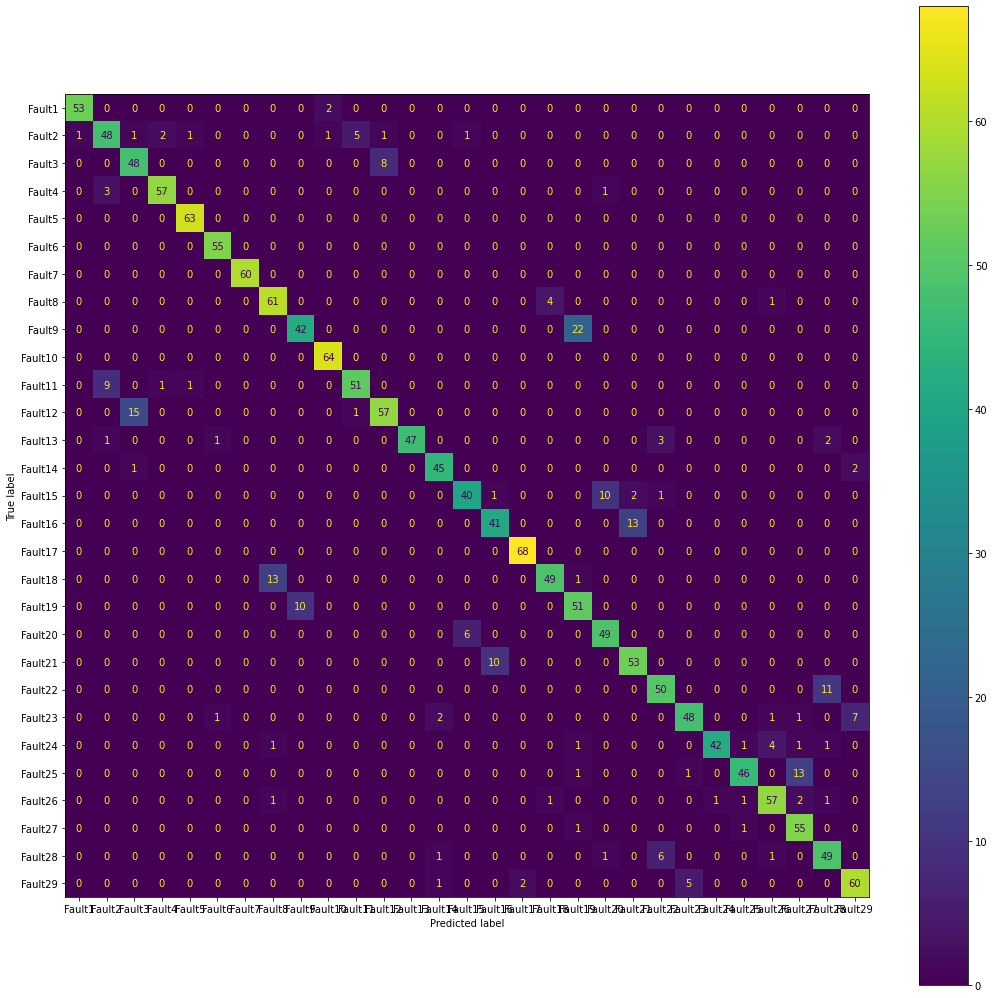

In [283]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import f1_score

model=trained_cnn_model
y_pred = model.predict(testX)
Y_pred=np.argmax(y_pred,axis=1)
Y_test=np.argmax(testy,axis=1)
# creating a confusion matrix
cm = confusion_matrix(Y_test,Y_pred)
fig, ax = plt.subplots(figsize=(18, 18))
Labels_=["Fault{}".format(i+1) for i in range(len(set(Y_test)))]
cmp = ConfusionMatrixDisplay(confusion_matrix(Y_test,Y_pred),display_labels=Labels_)
cmp.plot(ax=ax)
plt.show();

# Per Class Calculation
f1_score_PerClass=f1_score(Y_test, Y_pred, average=None)
ACC_PerClass=cm.diagonal()/cm.sum(axis=1)

In [324]:
f1_score_PerClass

array([1.        , 0.52083333, 0.625     , 0.85074627, 0.96923077,
       0.96078431, 1.        , 0.5648855 , 0.79518072, 0.91851852,
       0.66153846, 0.5046729 , 0.90909091, 0.89719626, 0.50549451,
       0.63636364, 0.94545455, 0.57627119, 0.52747253, 0.66197183,
       0.6993007 ])

In [325]:
ACC_PerClass

array([1.        , 0.75757576, 0.5625    , 0.75      , 0.96923077,
       0.94230769, 1.        , 0.61666667, 0.7173913 , 0.84931507,
       0.58108108, 0.55102041, 0.93220339, 0.94117647, 0.63888889,
       0.63636364, 0.94545455, 0.52307692, 0.72727273, 0.61038961,
       0.72463768])

In [ ]:
# Save Result for further analysis
pd.DataFrame(Y_test, Y_pred).reset_index().to_excel("confusion.xlsx")
pd.DataFrame(cnn_history.history['accuracy'],cnn_history.history['loss']).reset_index(inplace=True).to_excel("Acc&Loss.xlsx")

#  Classifing PQDs usning Transfer Learning

# useful Links:

#### [Different input shape handeling ](https://stackoverflow.com/questions/51995977/how-can-i-use-a-pre-trained-neural-network-with-grayscale-images)

#### [Transfer Learning on Greyscale Images ](https://towardsdatascience.com/transfer-learning-on-greyscale-images-how-to-fine-tune-pretrained-models-on-black-and-white-9a5150755c7a)  

#### [Practical Guide 1](https://towardsdatascience.com/practical-guide-to-transfer-learning-in-tensorflow-for-multiclass-image-classification-d35fab7b28c0)

#### [Practical Guide 2](https://www.geeksforgeeks.org/multiclass-image-classification-using-transfer-learning/)

In [55]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0, preprocess_input

TL_model=EfficientNetV2B0(include_top=False, weights="imagenet",input_shape=(224,224,3))

IMG_SIZE = 224
# Freeze base_model
TL_model.trainable = False

## Define model
input_tensor = keras.Input(shape=(IMG_SIZE,IMG_SIZE,1) )

##convert 2D gray image to 3D image for TL model 
x = layers.Conv2D(3,(3,3),padding='same')(input_tensor)    

x = TL_model(x, training=False)

# Rebuild top layers for 29 PQD Class
x = layers.GlobalAveragePooling2D()(x) # Average pooling operation
x = layers.BatchNormalization()(x) # Introduce batch norm
x = layers.Dropout(0.2)(x)  # Regularize with dropout

# Flattening to final layer
outputs = layers.Dense(29, activation='softmax')(x)

# Instantiate final Keras model with updated inputs and outputs
model = keras.Model(input_tensor, outputs)
model.summary()
model.compile(optimizer='adam', loss='CategoricalCrossentropy', metrics='Accuracy')

earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 3)       30        
                                                                 
 efficientnetv2-b0 (Function  (None, 7, 7, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                             

In [ ]:
trainX, testX,trainy,testy = train_test_split(X_cwt, dummy_y[:2],test_size=0.2)

history = model.fit(x=trainX,
                    y=trainy,
                    batch_size=32,
                    epochs=1,
                    verbose=2,
                    callbacks=earlystopping,
                    validation_data=(testX, testy))

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import f1_score

y_pred = model.predict(testX)
Y_pred=np.argmax(y_pred,axis=1)
Y_test=np.argmax(testy,axis=1)
# creating a confusion matrix
cm = confusion_matrix(Y_test,Y_pred)
fig, ax = plt.subplots(figsize=(18, 18))
Labels_=["Fault{}".format(i+1) for i in range(len(set(Y_test)))]
cmp = ConfusionMatrixDisplay(confusion_matrix(Y_test,Y_pred),display_labels=Labels_)
cmp.plot(ax=ax)
plt.show();

# Per Class Calculation
f1_score_PerClass=f1_score(Y_test, Y_pred, average=None)
ACC_PerClass=cm.diagonal()/cm.sum(axis=1)

# miscellaneous

In [134]:
# train autoencoder for classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot

# number of input columns
n_inputs = X.shape[1]
n_outputs=trainy.shape[1]

input_vec = Input(shape=(n_inputs, 1))  # adjust this to match your vector data

x = Conv1D(n_inputs*2, 16, activation='relu', padding='same')(input_vec)
x = MaxPooling1D(2, padding='same')(x)
encoded = Conv1D(n_inputs, 16, activation='relu', padding='same')(x)

x = Conv1D(n_inputs, 16, activation='relu', padding='same')(encoded)
x = MaxPooling1D(2, padding='same')(x)
x =Flatten()(x)
decoded =Dense(n_outputs, activation='softmax')(x)

# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# x = UpSampling1D(2)(x)
# decoded = Conv1D(n_outputs, 1, activation='softmax', padding='same')(x)

model = Model(input_vec, decoded)
# model.compile(optimizer='adam', loss='binary_crossentropy')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit the autoencoder model to reconstruct input
params=[trainX, testX,trainy,testy]
model.fit(params[0], params[2], epochs=20, batch_size=32, verbose=1, validation_data=(params[1], params[3]))
_, accuracy = model.evaluate(params[1], params[3], batch_size=64, verbose=1)
score = accuracy * 100.0
print(score)


# input_sig = Input(batch_shape=(1,n_inputs,1))
# x = Conv1D(n_inputs*2,16, activation='relu', padding='same',dilation_rate=2)(input_sig)
# x1 = MaxPooling1D(2)(x)
# x2 = Conv1D(n_inputs,16, activation='relu', padding='same',dilation_rate=2)(x1)
# x3 = MaxPooling1D(2)(x2)
# x4 = AveragePooling1D()(x3)
# flat = Flatten()(x4)
# encoded = Dense(2)(flat)
# d1 = Dense(n_inputs/2)(encoded)
# d2 = Reshape((4,200))(d1)
# d3 = Conv1D(200,1,strides=1, activation='relu', padding='same')(d2)
# d4 = UpSampling1D(2)(d3)
# d5 = Conv1D(400,1,strides=1, activation='relu', padding='same')(d4)
# d6 = UpSampling1D(2)(d5)
# d7 = UpSampling1D(2)(d6)
# decoded = Conv1D(n_outputs,1,strides=1, activation='softmax', padding='same')(d7)
# model= Model(input_sig, decoded)
# # output=Flatten()(d)
# # output = Dense(n_outputs, activation='softmax')(d)
# # output=Dense(n_outputs, activation='softmax')(output)

# # compile autoencoder model
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# # fit the autoencoder model to reconstruct input
# params=[trainX, testX,trainy,testy]
# model.fit(params[0], params[2], epochs=20, batch_size=32, verbose=1, validation_data=(params[1], params[3]))
# _, accuracy = model.evaluate(params[1], params[3], batch_size=64, verbose=1)
# score = accuracy * 100.0
# print(score)



Epoch 1/20
  4/725 [..............................] - ETA: 14:07:36 - loss: 83.2078 - accuracy: 0.0234 

KeyboardInterrupt: 

In [80]:
from tensorflow.keras.models import load_model
# define an encoder model (without the decoder)
encoder = Model(inputs=visible, outputs=bottleneck)
# plot_model(encoder, 'encoder_no_compress.png', show_shapes=True)
# save the encoder to file
encoder.save('encoder.h5')


# load the model from file
encoder = load_model('encoder.h5')
# encode the train data
X_train_encode = encoder.predict(trainX)
# encode the test data
X_test_encode = encoder.predict(testX)

# params=[X_train_encode, X_test_encode,trainy,testy]
# in_shape= (X_train_encode.shape[1],1)

params=[trainX, testX,trainy,testy]
in_shape= (trainX.shape[1],1)
# model = create_model(in_shape)

model.fit(params[0], params[2], epochs=30, batch_size=32, verbose=2)

_, accuracy = model.evaluate(params[1], params[3], batch_size=64, verbose=1)
score = accuracy * 100.0
print(score)